<img src="https://www.bu.edu/files/2022/07/feat-crop-iStock-1026002288.jpg" width=70%/>


**Alzheimer's disease** is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It's the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer's is irreversible and progressive.

Alzheimer's is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. Your doctor will likely perform a complete medical exam, including neurological, blood and brain imaging exams, such as CT, MRI or PET/CT of the head. There is no cure for Alzheimer's disease. However, your doctor may prescribe medication to slow the disease's progression and manage your symptoms.

**MRI of the head**: Magnetic resonance imaging (MRI) uses a powerful magnetic field, radio frequency pulses and a computer to produce detailed pictures of organs, soft tissues, bone and virtually all other internal body structures. MRI can detect brain abnormalities associated with mild cognitive impairment (MCI) and can be used to predict which patients with MCI may eventually develop Alzheimer's disease. In the early stages of Alzheimer's disease, an MRI scan of the brain may be normal. In later stages, MRI may show a decrease in the size of different areas of the brain (mainly affecting the temporal and parietal lobes).

## In this NoteBook

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

# 1. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
    
from helper_functions import plot_loss_curves

--2023-11-28 07:58:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-11-28 07:58:02 (15.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Uploading the Data

In [3]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 224
HEIGHT = 224
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '../input/augmented-alzheimer-mri-dataset-v2/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# 3. Defining Categories

In [4]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

### Calculating the number of images in each category in training data

In [5]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

MildDemented 8960 images
ModerateDemented 6464 images
NonDemented 9600 images
VeryMildDemented 8960 images


# 4. Creating Train and Validation DataFrame

In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(33984, 3)

In [7]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=4)

In [9]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [10]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(28886, 3)
(5098, 3)


In [11]:
train.head()

,file,category,category_id
0,train/ModerateDemented/d8965aa8-28d5-4aaa-9173...,ModerateDemented,1
1,train/ModerateDemented/7626aaf7-0b86-4bfc-a4ce...,ModerateDemented,1
2,train/ModerateDemented/01403b91-585b-4c6f-9de7...,ModerateDemented,1
3,train/ModerateDemented/61b79586-ee09-46d8-8bbb...,ModerateDemented,1
4,train/MildDemented/e7982532-5e59-4843-8122-17f...,MildDemented,0


In [12]:
validation.head()

,file,category,category_id
0,train/NonDemented/98b3507b-6258-4785-8dad-4d78...,NonDemented,2
1,train/NonDemented/be3eeed3-df5d-4b2b-9276-9bf1...,NonDemented,2
2,train/ModerateDemented/9a13b9e7-ccf5-4759-865f...,ModerateDemented,1
3,train/NonDemented/4507bd67-d551-49ea-8c6e-5e87...,NonDemented,2
4,train/VeryMildDemented/af5a3bc2-eaf5-4586-8629...,VeryMildDemented,3


# 5. Creating Test DataFrame

In [13]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(6400, 3)

# 6. Demonstrating Example Images

In [14]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

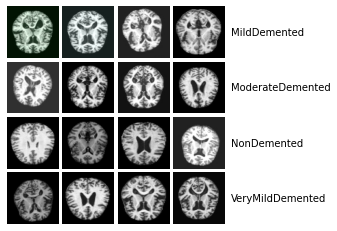

In [15]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0    
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
        
plt.show();

# 7. Keras ImageDataGenerator

In [16]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 28886 validated image filenames belonging to 4 classes.
Found 5098 validated image filenames belonging to 4 classes.


In [17]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# 8. Early Stopping

In [22]:
def get_callbacks(model_name):
    callbacks = []
    model_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-9, patience=10, verbose=True)
    model_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=True)
    model_cp = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, monitor='val_accuracy',
                           verbose=1)
    callbacks.extend([model_es, model_rlr, model_cp])
    return callbacks

# 9. Creating Model based on ResNet152V2

In [23]:
def create_model():
   
    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    for layers in resnet_model.layers[:100]:
        layers.trainable = True
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return res_model

In [24]:
res_model = create_model()

# 10. Training the Model

In [25]:
callbacks = get_callbacks('best_weights_resnet_tumor.h5')
history1 = res_model.fit(train_generator,
                    epochs=50, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[callbacks],
                    batch_size=32)

Epoch 1/50
100/100 [==============================] - 135s 1s/step - loss: 1.1418 - accuracy: 0.4497 - val_loss: 49.5114 - val_accuracy: 0.2766

Epoch 00001: val_accuracy improved from -inf to 0.27658, saving model to best_weights_resnet_tumor.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
100/100 [==============================] - 115s 1s/step - loss: 0.9307 - accuracy: 0.5606 - val_loss: 3.6855 - val_accuracy: 0.4337

Epoch 00002: val_accuracy improved from 0.27658 to 0.43370, saving model to best_weights_resnet_tumor.h5
Epoch 3/50
100/100 [==============================] - 116s 1s/step - loss: 0.8454 - accuracy: 0.6016 - val_loss: 9.6137 - val_accuracy: 0.3986

Epoch 00003: val_accuracy did not improve from 0.43370
Epoch 4/50
100/100 [==============================] - 116s 1s/step - loss: 0.8081 - accuracy: 0.6172 - val_loss: 7.0241 - val_accuracy: 0.4182

Epoch 00004: val_accuracy did not improve from 0.43370
Epoch 5/50
100/100 [==============================] - 116s 1s/step - loss: 0.8062 - accuracy: 0.6303 - val_loss: 1.9429 - val_accuracy: 0.4135

Epoch 00005: val_accuracy did not improve from 0.43370
Epoch 6/50
100/100 [==============================] - 115s 1s/step - loss: 0.7262 - accuracy: 0.6675 - val_loss: 1.7339 - val_accuracy: 0.5173

Epoch 0000

### Plotting the history of model

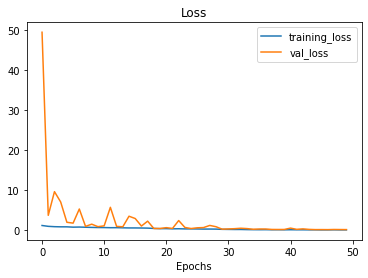

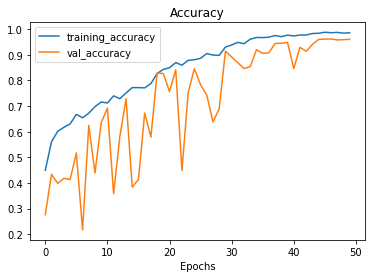

In [26]:
plot_loss_curves(history1)

# 10. Evaluation

In [27]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

160/160 [==============================] - 38s 236ms/step - loss: 0.1162 - accuracy: 0.9602

Train loss: 0.12
Train Accuracy: 96.02 %


In [28]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 60s 302ms/step - loss: 0.0471 - accuracy: 0.9836

Test loss: 0.05 
Test Accuracy: 98.36 %


In [29]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
MildDemented,0.998876,0.992188,0.995521,896.000000
ModerateDemented,1.000000,1.000000,1.000000,64.000000
NonDemented,0.978704,0.990938,0.984783,3200.000000
VeryMildDemented,0.984134,0.969196,0.976608,2240.000000
accuracy,0.983594,0.983594,0.983594,0.983594
macro avg,0.990429,0.988080,0.989228,6400.000000
weighted avg,0.983642,0.983594,0.983577,6400.000000


In [31]:
def create_model2():
   
    xceptionnet_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    xceptionnet_model.trainable = True

    x = xceptionnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    xception_model = tf.keras.Model(inputs=xceptionnet_model.input, outputs=predictions)

    # Compiling the model
    xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return xception_model

In [32]:
xception_model = create_model2()

83697664/83683744 [==============================] - 1s 0us/step


In [33]:
callbacks = get_callbacks('best_weights_xception_alzheimer.h5')
history = xception_model.fit(train_generator,
                    epochs=50, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[callbacks],
                    batch_size=32)

Epoch 1/50
100/100 [==============================] - 93s 864ms/step - loss: 1.1588 - accuracy: 0.4256 - val_loss: 389.7557 - val_accuracy: 0.2018

Epoch 00001: val_accuracy improved from -inf to 0.20184, saving model to best_weights_xception_alzheimer.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
100/100 [==============================] - 85s 847ms/step - loss: 0.7675 - accuracy: 0.6584 - val_loss: 4.5153 - val_accuracy: 0.6173

Epoch 00002: val_accuracy improved from 0.20184 to 0.61730, saving model to best_weights_xception_alzheimer.h5
Epoch 3/50
100/100 [==============================] - 85s 847ms/step - loss: 0.5991 - accuracy: 0.7269 - val_loss: 2.3690 - val_accuracy: 0.5192

Epoch 00003: val_accuracy did not improve from 0.61730
Epoch 4/50
100/100 [==============================] - 84s 845ms/step - loss: 0.5903 - accuracy: 0.7409 - val_loss: 2.1780 - val_accuracy: 0.5318

Epoch 00004: val_accuracy did not improve from 0.61730
Epoch 5/50
100/100 [==============================] - 84s 846ms/step - loss: 0.4966 - accuracy: 0.7922 - val_loss: 0.8068 - val_accuracy: 0.7062

Epoch 00005: val_accuracy improved from 0.61730 to 0.70616, saving model to best_weights_xception_alzheimer.h5
Epoch 6/50
100/100 [==============================] - 85s 847ms/step - loss: 0.3968 

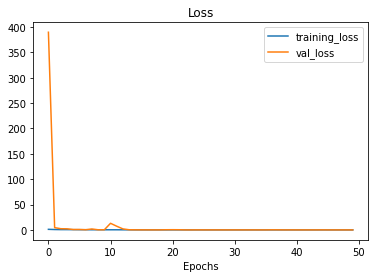

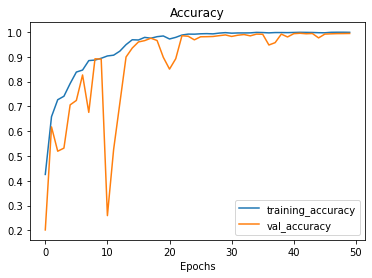

In [34]:
plot_loss_curves(history)

In [35]:
valid_loss, valid_accuracy = xception_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

160/160 [==============================] - 22s 137ms/step - loss: 0.0161 - accuracy: 0.9941

Train loss: 0.02
Train Accuracy: 99.41 %


In [36]:
loss, accuracy = xception_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 28s 141ms/step - loss: 0.0030 - accuracy: 0.9989

Test loss: 0.00 
Test Accuracy: 99.89 %


In [37]:
y_predict = xception_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
MildDemented,1.000000,1.000000,1.000000,896.000000
ModerateDemented,1.000000,1.000000,1.000000,64.000000
NonDemented,0.997817,1.000000,0.998907,3200.000000
VeryMildDemented,1.000000,0.996875,0.998435,2240.000000
accuracy,0.998906,0.998906,0.998906,0.998906
macro avg,0.999454,0.999219,0.999336,6400.000000
weighted avg,0.998909,0.998906,0.998906,6400.000000


In [43]:
def create_model3():
   
    densenet_model = tf.keras.applications.densenet.DenseNet201(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    densenet_model.trainable = True

    x = densenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    dense_model = tf.keras.Model(inputs=densenet_model.input, outputs=predictions)

    # Compiling the model
    dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return dense_model

In [44]:
dense_model = create_model3()

74850304/74836368 [==============================] - 0s 0us/step


In [45]:
callbacks = get_callbacks('best_weights_densenet_alzheimer.h5')
history = dense_model.fit(train_generator,
                    epochs=50, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[callbacks],
                    batch_size=32)

Epoch 1/35
100/100 [==============================] - 111s 852ms/step - loss: 1.0466 - accuracy: 0.5325 - val_loss: 429.6692 - val_accuracy: 0.1918

Epoch 00001: val_accuracy improved from -inf to 0.19184, saving model to best_weights_densenet_alzheimer.h5
Epoch 2/35
100/100 [==============================] - 80s 803ms/step - loss: 0.7834 - accuracy: 0.6256 - val_loss: 3.4942 - val_accuracy: 0.4745

Epoch 00002: val_accuracy improved from 0.19184 to 0.47450, saving model to best_weights_densenet_alzheimer.h5
Epoch 3/35
100/100 [==============================] - 80s 799ms/step - loss: 0.7248 - accuracy: 0.6644 - val_loss: 1.8714 - val_accuracy: 0.6040

Epoch 00003: val_accuracy improved from 0.47450 to 0.60396, saving model to best_weights_densenet_alzheimer.h5
Epoch 4/35
100/100 [==============================] - 80s 798ms/step - loss: 0.6525 - accuracy: 0.7044 - val_loss: 6.0938 - val_accuracy: 0.3272

Epoch 00004: val_accuracy did not improve from 0.60396
Epoch 5/35
100/100 [========

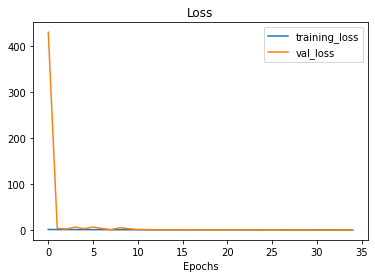

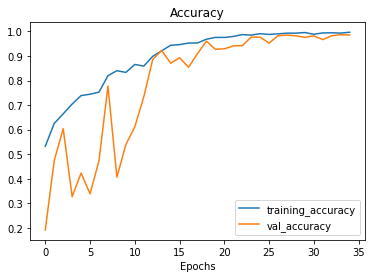

In [46]:
plot_loss_curves(history)

In [47]:
valid_loss, valid_accuracy = dense_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

160/160 [==============================] - 25s 154ms/step - loss: 0.0459 - accuracy: 0.9853

Train loss: 0.05
Train Accuracy: 98.53 %


In [48]:
loss, accuracy = dense_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 31s 153ms/step - loss: 0.0211 - accuracy: 0.9912

Test loss: 0.02 
Test Accuracy: 99.12 %


In [49]:
y_predict = dense_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
MildDemented,0.998884,0.998884,0.998884,896.00000
ModerateDemented,1.000000,1.000000,1.000000,64.00000
NonDemented,0.984886,0.997812,0.991307,3200.00000
VeryMildDemented,0.997270,0.978571,0.987832,2240.00000
accuracy,0.991250,0.991250,0.991250,0.99125
macro avg,0.995260,0.993817,0.994506,6400.00000
weighted avg,0.991331,0.991250,0.991239,6400.00000


In [50]:
def baggingClassificationAlzheimer(img, model1, model2):
    labels=["Mildly demented", "Moderately demented", "Non demented", "Very mildly demented"]
#     img = cv2.resize(img, (224, 224))
#     img = img.astype('float32')
#     img /= 255.0
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.resize((1, 224, 224, 3))
    prediction1 = model1.predict(img, verbose=0)
    prediction2 = model2.predict(img, verbose=0)
    prediction_list1 = prediction1[0].tolist()
    for label in range(len(prediction_list1)):
        prediction_list1[label] = float(prediction_list1[label])*100
    prediction_list2 = prediction2[0].tolist()
    for label in range(len(prediction_list2)):
        prediction_list2[label] = float(prediction_list2[label])*100
    predictions = []
    for idx in range(len(prediction_list1)):
        predictions.append(prediction_list1[idx]+prediction_list2[idx])
    labels_predictions = zip(labels, predictions)
    sorted_predictions = sorted(labels_predictions, reverse = True, key = lambda x : x[1])
    return sorted_predictions[0][0]

In [51]:
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing import image


model1 = tf.keras.models.load_model(
    '/kaggle/working/best_weights_resnet_tumor.h5'
)
model2 = tf.keras.models.load_model(
    '/kaggle/working/best_weights_densenet_alzheimer.h5'
)

correctly_classified_images = 0
total_images = 0
directory = '/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val'
for root, dirs, files in os.walk(directory):
    for name in files:
        total_images += 1
        img_name = os.path.join(root, name)
        img = image.load_img(img_name, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        prediction = baggingClassificationAlzheimer(img_array, model1, model2)
        if('MildDemented' in img_name and prediction == "Mildly demented"):
            correctly_classified_images += 1
        elif('ModerateDemented' in img_name and prediction == "Moderately demented"):
            correctly_classified_images += 1
        elif('NonDemented' in img_name and prediction == 'Non demented'):
            correctly_classified_images += 1
        elif('VeryMildDemented' in img_name and prediction == 'Very mildly demented'):
            correctly_classified_images += 1

print("The number of correctly classified images out of a total of", total_images, "is", correctly_classified_images)
print("The percentage of correctly classified images is", correctly_classified_images*1.0/total_images)

The number of correctly classified images out of a total of 6400 is 6387
The percentage of correctly classified images is 0.99796875
